In [1]:
!git clone https://github.com/ezaaputra/indonlu.git
# !pip install transformer

import os

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict

# NN
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer, AlbertForSequenceClassification
# from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from transformers import AutoTokenizer

Cloning into 'indonlu'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 460 (delta 119), reused 108 (delta 108), pack-reused 312
Receiving objects: 100% (460/460), 4.83 MiB | 8.58 MiB/s, done.
Resolving deltas: 100% (229/229), done.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#df = pd.read_excel("/content/drive/MyDrive/00. Drive PC/1.STIS/SEMNAS 2024/data_bert_all.xlsx")
df = pd.read_excel("data_bert_all (1).xlsx")
df

,Unnamed: 0,Judul,Tanggal,Link,Berita,Kode,Label_1,Label_2,Label Fix,Unnamed: 8,Cleaned Berita,Unnamed: 11
0,0,Indonesia Siap Perangi COVID Lagi,22 Mei 2024 15:15,https://health.detik.com/detikhealth/d-7352983...,Beberapa periode berselang hingga temuan kasus...,0.0,NaN,NaN,ihsg turun,639.0,beberapa periode berselang hingga temuan kasus...,Count
1,1,"ISHG Dibuka di Zona Hijau, Kembali ke Zona 7.2...",22 Mei 2024 09:13,https://finance.detik.com/bursa-dan-valas/d-73...,Indeks Harga Saham Gabungan (IHSG) pagi ini di...,NaN,ihsg naik,ihsg naik,ihsg naik,NaN,indeks harga saham gabungan (ihsg) pagi ini di...,1349
2,2,IHSG Dibuka di Zona Hijau Usai Kemarin Melempem,21 Mei 2024 09:12,https://finance.detik.com/bursa-dan-valas/d-73...,Indeks Harga Saham Gabungan (IHSG) pagi ini di...,NaN,ihsg naik,ihsg naik,ihsg naik,NaN,indeks harga saham gabungan (ihsg) pagi ini di...,1754
3,3,"Dibuka di Zona Hijau, IHSG Sore Ini Ditutup Me...",20 Mei 2024 16:31,https://finance.detik.com/bursa-dan-valas/d-73...,Indeks Harga Saham Gabungan (IHSG) menutup per...,NaN,ihsg turun,ihsg turun,ihsg turun,NaN,indeks harga saham gabungan (ihsg) menutup per...,NaN
4,4,Misteri di Balik Jatuhnya Pesawat Latih,20 Mei 2024 15:15,https://news.detik.com/berita/d-7349177/mister...,Pesawat latih bernomor registrasi PK-IFP Itu j...,0.0,NaN,NaN,ihsg turun,NaN,pesawat latih bernomor registrasi pk-ifp itu j...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3098,3098,"Sepanjang Hari Lesu, IHSG Berakhir di 6.056",30 Nov 2018 16:50,https://finance.detik.com/bursa-dan-valas/d-43...,Indeks Harga Saham Gabungan (IHSG) sepanjang h...,NaN,ihsg turun,ihsg turun,ihsg turun,NaN,indeks harga saham gabungan (ihsg) sepanjang h...,NaN
3099,3099,"Jeda Siang, IHSG Parkir di Zona Merah",30 Nov 2018 11:50,https://finance.detik.com/bursa-dan-valas/d-43...,\n \n \n SCROLL TO CONTINUE WITH CONTEN...,0.0,NaN,NaN,ihsg turun,NaN,saham yang masuk jajaran top gainers di antara...,NaN
3100,3100,Dukungan OJK untuk Kurangi Dampak Tekanan Pasa...,28 Sep 2018 00:00,https://news.detik.com/adv-nhl-detikcom/d-4233...,Berlanjutnya isu perang dagang antara Amerika ...,1.0,NaN,NaN,ihsg naik,NaN,berlanjutnya isu perang dagang antara amerika ...,NaN
3101,3101,NH Korindo Securities: IHSG Bakal Melemah Tert...,04 Sep 2018 09:00,https://finance.detik.com/market-research/d-41...,IHSG bergerak melemah kemarin di tengah pelema...,NaN,ihsg turun,ihsg turun,ihsg turun,NaN,ihsg bergerak melemah kemarin di tengah pelema...,NaN


In [4]:
df.isna().sum()

Unnamed: 0           0
Judul                0
Tanggal              0
Link                 0
Berita               2
Kode              2466
Label_1            639
Label_2            639
Label Fix            0
Unnamed: 8        3102
Cleaned Berita       5
Unnamed: 11       3100
dtype: int64

In [5]:
df.dropna(axis=1)
df.dropna(how='all')
df_cleaned = df.dropna(subset=['Kode'])

In [6]:
df_cleaned.isna().sum()

Unnamed: 0          0
Judul               0
Tanggal             0
Link                0
Berita              2
Kode                0
Label_1           637
Label_2           637
Label Fix           0
Unnamed: 8        636
Cleaned Berita      5
Unnamed: 11       636
dtype: int64

In [7]:
df = df_cleaned.copy()

In [8]:
texts = [str(text) for text in df['Cleaned Berita'].tolist()]
label = df['Label Fix'].tolist()

In [9]:
df = pd.DataFrame({
    'Berita':texts,
    'Label':label
})
# df.to_excel("data_bert_clean.xlsx")
df

,Berita,Label
0,beberapa periode berselang hingga temuan kasus...,ihsg turun
1,pesawat latih bernomor registrasi pk-ifp itu j...,ihsg turun
2,kekhawatiran masyarakat soal perubahan tarif a...,ihsg naik
3,rapat pleno penyusunan ruu kementerian negara ...,ihsg turun
4,proses pembentukan panitia seleksi (pansel) ca...,ihsg turun
...,...,...
632,nan,ihsg naik
633,sementara nilai tukar rupiah tampak melemah di...,ihsg turun
634,saham yang masuk jajaran top gainers di antara...,ihsg turun
635,berlanjutnya isu perang dagang antara amerika ...,ihsg naik


In [10]:
# Menemukan baris dengan string "nan"
nan_string_rows = df[df['Berita'] == 'nan']

print("Baris dengan string 'nan':")
print(nan_string_rows)

Baris dengan string 'nan':
    Berita       Label
488    nan  ihsg turun
613    nan   ihsg naik
628    nan   ihsg naik
629    nan   ihsg naik
632    nan   ihsg naik


In [11]:
# Menghapus baris dengan string "nan"
df = df[df['Berita'] != 'nan']

print("\nDataFrame setelah menghapus baris dengan string 'nan':")
print(df_cleaned)


DataFrame setelah menghapus baris dengan string 'nan':
      Unnamed: 0                                              Judul  \
0              0                  Indonesia Siap Perangi COVID Lagi   
4              4            Misteri di Balik Jatuhnya Pesawat Latih   
7              7    Paradoks Keadilan di Aturan Baru BPJS Kesehatan   
9              9  Revisi Undang-undang Kementerian, Siapa Punya ...   
11            11  Menanti Warisan Jokowi untuk Pemberantasan Kor...   
...          ...                                                ...   
3075        3075                Data BEI: IHSG Urutan ke-8 di Dunia   
3078        3078  Kompak dengan Bursa Asia, IHSG Dibuka di Zona ...   
3099        3099              Jeda Siang, IHSG Parkir di Zona Merah   
3100        3100  Dukungan OJK untuk Kurangi Dampak Tekanan Pasa...   
3102        3102  Lira Turki Anjlok, Mengapa Indonesia Tak Berpe...   

                  Tanggal                                               Link  \
0      22 M

In [12]:
# common functions
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_params(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}: {:.2f}'.format(key, value))
    return ' '.join(string_list)

# Set random seed
set_seed(222112058)
print(set_seed)

<function set_seed at 0x7dc1666e1630>


In [13]:
train_set, val_set = train_test_split(df,test_size=0.3, stratify=df.Label, random_state=43)
val_set, test_set = train_test_split(val_set, test_size=0.33, stratify=val_set.Label, random_state=43)

In [14]:
print(f"Train shape : {train_set.shape}")
print(f"Val shape : {val_set.shape} ")
print(f"Test shape : {test_set.shape} ")

Train shape : (442, 2)
Val shape : (127, 2) 
Test shape : (63, 2) 


In [15]:
train_set.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('test_set.tsv', sep='\t', header=None, index=False)

In [16]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
#####
# Document Sentiment Prosa
#####
class DocumentSentimentDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = {'ihsg turun': 0, 'ihsg naik': 1}
    INDEX2LABEL = {0: 'ihsg turun', 1: 'ihsg naik'}
    NUM_LABELS = 2

    def load_dataset(self, path):
        df = pd.read_csv(path, sep='\t', header=None)
        df.columns = ['text','sentiment']
        df['sentiment'] = df['sentiment'].apply(lambda lab: self.LABEL2INDEX[lab])
        return df

    def __init__(self, dataset_path, tokenizer, no_special_token=False, *args, **kwargs):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token

    def __getitem__(self, index):
        data = self.data.loc[index,:]
        text, sentiment = data['text'], data['sentiment']
        subwords = self.tokenizer.encode(text, add_special_tokens=not self.no_special_token)
        return np.array(subwords), np.array(sentiment), data['text']

    def __len__(self):
        return len(self.data)

class DocumentSentimentDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(DocumentSentimentDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len

    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)

        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        sentiment_batch = np.zeros((batch_size, 1), dtype=np.int64)

        seq_list = []
        for i, (subwords, sentiment, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i,:len(subwords)] = subwords
            mask_batch[i,:len(subwords)] = 1
            sentiment_batch[i,0] = sentiment

            seq_list.append(raw_seq)

        return subword_batch, mask_batch, sentiment_batch, seq_list

In [17]:
# Load Tokenizer and Config

model_checkpoint = "indobenchmark/indobert-lite-large-p2"
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
config = BertConfig.from_pretrained(model_checkpoint)
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = AlbertForSequenceClassification.from_pretrained(model_checkpoint, config=config)

# model = AutoModel.from_pretrained(model_checkpoint)

# Struktur model
print(model)

# Jumlah parameter
print(count_params(model))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
You are using a model of type albert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/70.7M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-large-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=1024, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_featur

In [18]:
berita = df.Berita.values
tokenized_texts = tokenizer.tokenize(berita[74])

input_ids = []

for sent in berita:
    encoded_sent = tokenizer.encode(
        sent,
        add_special_tokens = True
    )
    input_ids.append(encoded_sent)

print("Original: ", berita[74])
print("Tokenized: ", tokenized_texts)
print("Token IDs: ", input_ids[74])

Original:  saham emiten pertambangan nikel yakni pt vale indonesia tbk (inco) terpantau ambles pada perdagangan sesi ii, jumat (16/2/2024). kondisi ini terjadi setelah adanya kabar bahwa proses divestasi 14% saham perusahaan kepada holding bumn pertambangan, mind id, telah disepakati.dikutip dari rti pada pukul 16.00 wib, saham inco ditutup di level rp 3.690/saham. saham inco terpantau ambles 7,75% alias turun rp 310 dari nilainya saat pembukaan sebesar rp 3.950/saham. adapun pergerakan sahamnya hari ini berada pada rentang harga rp 3.650-4.000 per unit.saham inco sendiri terpantau menukik tajam pada pukul 14.00. pada jam tersebut, saham inco dijual dalam posisi di kisaran rp 3.950/saham, kemudian langsung turun hingga ke level rp 3.860/saham. saham inco terus berfluktuasi hingga akhirnya ditutup di level rp 3.690/saham. saham inco pada perdagangan hari ini telah ditransaksikan sebanyak 15.637, dengan volume sebesar 52,47 juta lembar saham. sementara untuk nilai transaksinya sudah menc

In [19]:
train_dataset_path = "/content/train_set.tsv"
valid_dataset_path = "/content/val_set.tsv"
test_dataset_path = "/content/test_set.tsv"

In [20]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=8, num_workers=0, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=8, num_workers=0, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=8, num_workers=0, shuffle=False)

In [21]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'ihsg turun': 0, 'ihsg naik': 1}
{0: 'ihsg turun', 1: 'ihsg naik'}


In [22]:
optimizer = optim.Adam(model.parameters(), lr = 1e-5)
model = model.cuda()

In [23]:
# List to store validation loss for each epoch
# validation_losses = []

train_loss_lists = []
train_acc_lists = []
eval_loss_lists = []
eval_acc_lists = []

# Train
n_epochs = 5
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))
    train_acc_lists.append(metrics['ACC'])
    current_train_loss = round(total_train_loss/(i+1), 4)
    train_loss_lists.append(current_train_loss)

    # Evaluate on validation
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Calculate total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Calculate evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))
    eval_acc_lists.append(metrics['ACC'])
    current_eval_loss = round(total_loss/(i+1), 4)
    eval_loss_lists.append(current_eval_loss)

(Epoch 1) TRAIN LOSS:0.6950 LR:0.00001000: 100%|██████████| 56/56 [02:01<00:00,  2.16s/it]


(Epoch 1) TRAIN LOSS:0.6950 ACC: 0.56 F1: 0.43 REC: 0.51 PRE: 0.53 LR:0.00001000


  0%|          | 0/16 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.6037 ACC: 0.75 F1: 0.43 REC: 0.50 PRE: 0.38:   6%|▋         | 1/16 [00:00<00:12,  1.21it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
VALID LOSS:0.6345 ACC: 0.69 F1: 0.41 REC: 0.50 PRE: 0.34:  12%|█▎        | 2/16 [00:01<00:11,  1.21it/s]/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in la

(Epoch 1) VALID LOSS:0.6816 ACC: 0.57 F1: 0.36 REC: 0.50 PRE: 0.28


(Epoch 2) TRAIN LOSS:0.6693 LR:0.00001000: 100%|██████████| 56/56 [02:04<00:00,  2.23s/it]


(Epoch 2) TRAIN LOSS:0.6693 ACC: 0.57 F1: 0.46 REC: 0.52 PRE: 0.56 LR:0.00001000


VALID LOSS:0.6999 ACC: 0.53 F1: 0.52 REC: 0.52 PRE: 0.52: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s]


(Epoch 2) VALID LOSS:0.6999 ACC: 0.53 F1: 0.52 REC: 0.52 PRE: 0.52


(Epoch 3) TRAIN LOSS:0.6631 LR:0.00001000: 100%|██████████| 56/56 [02:07<00:00,  2.28s/it]


(Epoch 3) TRAIN LOSS:0.6631 ACC: 0.59 F1: 0.52 REC: 0.55 PRE: 0.59 LR:0.00001000


VALID LOSS:0.6745 ACC: 0.58 F1: 0.55 REC: 0.56 PRE: 0.57: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]


(Epoch 3) VALID LOSS:0.6745 ACC: 0.58 F1: 0.55 REC: 0.56 PRE: 0.57


(Epoch 4) TRAIN LOSS:0.6540 LR:0.00001000: 100%|██████████| 56/56 [02:05<00:00,  2.24s/it]


(Epoch 4) TRAIN LOSS:0.6540 ACC: 0.60 F1: 0.58 REC: 0.58 PRE: 0.59 LR:0.00001000


VALID LOSS:0.6837 ACC: 0.57 F1: 0.52 REC: 0.53 PRE: 0.54: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s]


(Epoch 4) VALID LOSS:0.6837 ACC: 0.57 F1: 0.52 REC: 0.53 PRE: 0.54


(Epoch 5) TRAIN LOSS:0.6501 LR:0.00001000: 100%|██████████| 56/56 [02:07<00:00,  2.27s/it]


(Epoch 5) TRAIN LOSS:0.6501 ACC: 0.64 F1: 0.62 REC: 0.62 PRE: 0.63 LR:0.00001000


VALID LOSS:0.6676 ACC: 0.57 F1: 0.57 REC: 0.57 PRE: 0.57: 100%|██████████| 16/16 [00:13<00:00,  1.16it/s]

(Epoch 5) VALID LOSS:0.6676 ACC: 0.57 F1: 0.57 REC: 0.57 PRE: 0.57


In [24]:
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 0, 'Epoch')

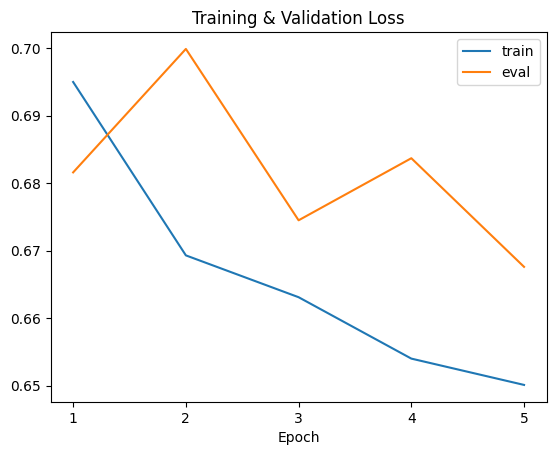

In [25]:
plt.plot(train_loss_lists, label='train')
plt.plot(eval_loss_lists, label='eval')
plt.title('Training & Validation Loss')
plt.xticks(np.arange(len(train_loss_lists)), np.arange(1, len(eval_loss_lists)+1))
plt.legend()
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

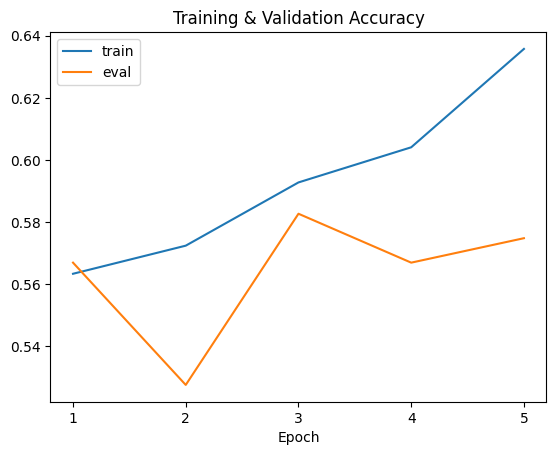

In [26]:
plt.plot(train_acc_lists, label='train')
plt.plot(eval_acc_lists, label='eval')
plt.title('Training & Validation Accuracy')
plt.xticks(np.arange(len(train_acc_lists)), np.arange(1, len(eval_acc_lists)+1))
plt.legend()
plt.xlabel('Epoch')

In [31]:
# Evaluate on test
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp
    list_label += batch_label

# Save prediction

100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


In [32]:
list_hyp, list_label

(['ihsg turun',
  'ihsg naik',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  'ihsg naik',
  'ihsg turun',
  'ihsg naik',
  'ihsg turun',
  'ihsg naik',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg naik',
  'ihsg turun'],
 ['ihsg turun',
  

In [33]:
metrics = document_sentiment_metrics_fn(list_hyp, list_label)
metrics

{'ACC': 0.6825396825396826,
 'F1': 0.682459677419355,
 'REC': 0.6928571428571428,
 'PRE': 0.6944444444444444}

In [34]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(list_label, list_hyp)

cm

array([[21, 14],
       [ 6, 22]])

In [35]:
report = classification_report(list_label, list_hyp, digits=4)

print(report)

              precision    recall  f1-score   support

   ihsg naik     0.7778    0.6000    0.6774        35
  ihsg turun     0.6111    0.7857    0.6875        28

    accuracy                         0.6825        63
   macro avg     0.6944    0.6929    0.6825        63
weighted avg     0.7037    0.6825    0.6819        63

